Training Samples: 8175, Test Samples: 2044
Model Performance:
RMSE: 66.50
R2 Score: 0.9543


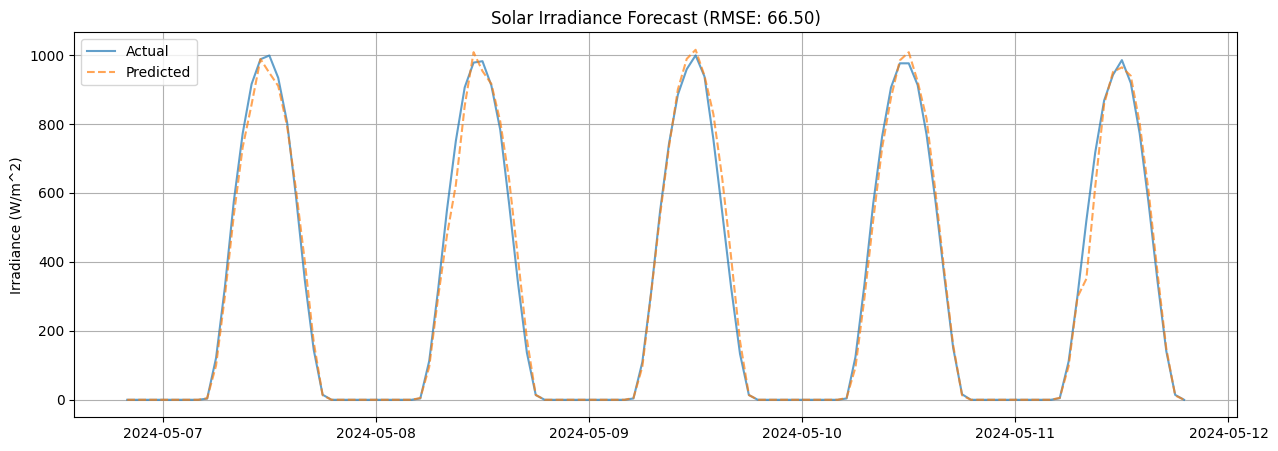


Feature Importance:
SZA            0.861844
hour_cos       0.050858
T2M            0.032368
PRECTOTCORR    0.019844
WSC            0.013459
PS             0.007902
month_cos      0.007334
month_sin      0.003588
hour_sin       0.002804
dtype: float64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 1. Load and Clean Data
# ==========================================
# Load data
df = pd.read_csv('Ahmedabad solar irradiance.csv') # Adjust path if needed

# CRITICAL STEP: The dataset uses -999.0 as a placeholder for missing values.
# Inspection shows ~7000 rows have missing targets. We must drop these rows 
# because we cannot train on missing ground truth.
df_clean = df[df['ALLSKY_SFC_SW_DWN'] != -999.0].copy()

# 'ALLSKY_KT' (Clearness Index) is missing often (likely undefined at night).
# We will drop this column to avoid data leakage or noise.
df_clean = df_clean.drop(columns=['ALLSKY_KT'])

# Create a Datetime Index
df_clean['Datetime'] = pd.to_datetime(df_clean[['YEAR', 'MO', 'DY', 'HR']].rename(
    columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}))
df_clean = df_clean.set_index('Datetime').sort_index()

# ==========================================
# 2. Feature Engineering
# ==========================================
# Cyclic encoding for Hour and Month (Crucial for time series)
# This helps the model understand that Hour 23 is close to Hour 0.
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['HR'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['HR'] / 24)
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['MO'] / 12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['MO'] / 12)

# Select Features and Target
features = ['SZA', 'T2M', 'PS', 'WSC', 'PRECTOTCORR', 
            'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
target = 'ALLSKY_SFC_SW_DWN'

X = df_clean[features]
y = df_clean[target]

# ==========================================
# 3. Train/Test Split (Time Series)
# ==========================================
# We CANNOT use random shuffle. We must split by time.
# Train on first 80%, Test on last 20%
split_point = int(len(df_clean) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Training Samples: {len(X_train)}, Test Samples: {len(X_test)}")

# ==========================================
# 4. Modeling (Random Forest)
# ==========================================
# Using Random Forest as it handles non-linear weather relationships well
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# ==========================================
# 5. Evaluation
# ==========================================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:\nRMSE: {rmse:.2f}\nR2 Score: {r2:.4f}")

# Visualization: Actual vs Predicted (First 5 days of test set)
plt.figure(figsize=(15, 5))
subset = 24 * 5 # 5 Days
plt.plot(y_test.index[:subset], y_test.values[:subset], label='Actual', alpha=0.7)
plt.plot(y_test.index[:subset], y_pred[:subset], label='Predicted', alpha=0.7, linestyle='--')
plt.title(f'Solar Irradiance Forecast (RMSE: {rmse:.2f})')
plt.ylabel('Irradiance (W/m^2)')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance:")
print(importances)